<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/MNIST1-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [50]:
gen = torch.Generator()
gen.manual_seed(42)

# construct the MNIST dataset

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, drop_last=True, generator=gen)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, drop_last=True, generator=gen)

In [55]:
# build various necessary models

class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.ff1 = nn.Linear(28*28, 256)
    self.ff2 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = torch.relu(self.ff1(x))
    x = self.ff2(x)
    return x

class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(1, 64, (3,3), padding=1) #batch,32,28,28
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #batch,32,14,14
    self.cnn2 = nn.Conv2d(64, 128, (3,3), padding=1) #batch,64,14,14
    self.fc1 = nn.Linear(128*14*14, 256) #batch, 256
    self.fc2 = nn.Linear(256, 10) #256, 10

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)
    self.dropout = nn.Dropout(0.5)

    nn.init.xavier_normal_(self.fc1.weight, generator=gen)
    nn.init.xavier_normal_(self.fc2.weight, generator=gen)

    torch.manual_seed(gen.initial_seed())

  def forward(self, x):
    x = self.pool(F.gelu(self.bn1((self.cnn1(x)))))
    x = F.gelu(self.bn2(self.cnn2(x)))
    x = x.view(-1, 128*14*14)
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.fc2(x)
    return x


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device}')

model = SimpleCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

using cuda
6500234


In [57]:
# train
import time

epochs = 10



for epoch in range(epochs):
  start_time = time.time()
  model.train()

  running_loss = 0.0
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    actual_loss = running_loss/len(trainloader)
  scheduler.step()
  end_time = time.time()
  elapsed_time = end_time - start_time

  print(f'Epoch: {epoch+1}, Loss: {actual_loss:.6f}, Learning Rate: {scheduler.get_last_lr()[0]:.2e}, time: {elapsed_time:.2f} seconds')

#training with cpu I got
# Epoch: 2, Loss: 0.1701388326746868, Learning Rate: 0.0002187, time: 22.8031 seconds
# Epoch: 3, Loss: 0.14236244769804696, Learning Rate: 0.00019683, time: 24.0346 seconds
# Epoch: 4, Loss: 0.12520508436344985, Learning Rate: 0.000177147, time: 22.7670 seconds
# Epoch: 5, Loss: 0.11304322813549093, Learning Rate: 0.0001594323, time: 22.0178 seconds
# Epoch: 6, Loss: 0.10449721171295026, Learning Rate: 0.00014348907, time: 22.6968 seconds
# Epoch: 7, Loss: 0.09796476642041603, Learning Rate: 0.000129140163, time: 25.6630 seconds
# Epoch: 8, Loss: 0.0930745871121356, Learning Rate: 0.0001162261467, time: 26.7959 seconds
# Epoch: 9, Loss: 0.08865620274088776, Learning Rate: 0.00010460353203, time: 22.8440 seconds
# Epoch: 10, Loss: 0.08525394566114614, Learning Rate: 9.4143178827e-05, time: 22.8985 seconds

#training with gpu I got (0.2GB gpu usage)
# Epoch: 1, Loss: 0.5424798246922335, Learning Rate: 0.00027, time: 14.8868 seconds
# Epoch: 2, Loss: 0.2115283296021097, Learning Rate: 0.000243, time: 14.6707 seconds
# Epoch: 3, Loss: 0.16056824648671306, Learning Rate: 0.0002187, time: 21.5765 seconds
# Epoch: 4, Loss: 0.13215783343172316, Learning Rate: 0.00019683, time: 17.6151 seconds
# Epoch: 5, Loss: 0.11415848696630214, Learning Rate: 0.000177147, time: 18.7395 seconds
# Epoch: 6, Loss: 0.10268125734853548, Learning Rate: 0.0001594323, time: 16.5788 seconds
# Epoch: 7, Loss: 0.09362162741074058, Learning Rate: 0.00014348907, time: 14.2623 seconds
# Epoch: 8, Loss: 0.08736622443357075, Learning Rate: 0.000129140163, time: 16.5197 seconds
# Epoch: 9, Loss: 0.08213834122435579, Learning Rate: 0.0001162261467, time: 16.5810 seconds
# Epoch: 10, Loss: 0.0781637357737722, Learning Rate: 0.00010460353203, time: 17.3101 seconds

#optimize (1.9GB gpu usage)
# Epoch: 1, Loss: 0.312318, Learning Rate: 2.7000e-04, time: 14.6511 seconds
# Epoch: 2, Loss: 0.078297, Learning Rate: 2.4300e-04, time: 14.4629 seconds
# Epoch: 3, Loss: 0.049530, Learning Rate: 2.1870e-04, time: 14.5730 seconds
# Epoch: 4, Loss: 0.037332, Learning Rate: 1.9683e-04, time: 17.5865 seconds
# Epoch: 5, Loss: 0.027571, Learning Rate: 1.7715e-04, time: 14.5893 seconds
# Epoch: 6, Loss: 0.022299, Learning Rate: 1.5943e-04, time: 14.3388 seconds
# Epoch: 7, Loss: 0.017858, Learning Rate: 1.4349e-04, time: 14.5865 seconds
# Epoch: 8, Loss: 0.014720, Learning Rate: 1.2914e-04, time: 14.5145 seconds
# Epoch: 9, Loss: 0.011913, Learning Rate: 1.1623e-04, time: 15.0431 seconds
# Epoch: 10, Loss: 0.010285, Learning Rate: 1.0460e-04, time: 14.3441 seconds

Epoch: 1, Loss: 0.436106, Learning Rate: 2.70e-04, time: 18.61 seconds
Epoch: 2, Loss: 0.103045, Learning Rate: 2.43e-04, time: 21.00 seconds
Epoch: 3, Loss: 0.068443, Learning Rate: 2.19e-04, time: 16.73 seconds
Epoch: 4, Loss: 0.051265, Learning Rate: 1.97e-04, time: 16.78 seconds
Epoch: 5, Loss: 0.039316, Learning Rate: 1.77e-04, time: 16.41 seconds
Epoch: 6, Loss: 0.032605, Learning Rate: 1.59e-04, time: 16.87 seconds
Epoch: 7, Loss: 0.027582, Learning Rate: 1.43e-04, time: 16.36 seconds
Epoch: 8, Loss: 0.024207, Learning Rate: 1.29e-04, time: 15.97 seconds
Epoch: 9, Loss: 0.021101, Learning Rate: 1.16e-04, time: 18.05 seconds
Epoch: 10, Loss: 0.017846, Learning Rate: 1.05e-04, time: 16.23 seconds


In [58]:
correct = 0
total = 0
with torch.no_grad():
  model.eval()
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, indices = torch.max(outputs, dim=1)
    correct += (indices == labels).sum().item()
    total += labels.shape[0]

print(f'test data accuracy: {correct/total:.4f}')
#training with cpu I got
#test data accuracy: 0.9744

#training with gpu I got
#test data accuracy: 0.9779

#optimize
#test data accuracy: 0.9908

test data accuracy: 0.9908


In [59]:
import matplotlib.pyplot as plt

intelligible = []
answers = []
model_predictions = []

with torch.no_grad():
  model.eval()
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, indices = torch.max(outputs, dim=1)
    incorrect = labels != indices

    if sum(incorrect) != 0:
      answer = labels[incorrect]
      model_prediction = indices[incorrect]

      answers.append(answer)
      model_predictions.append(model_prediction)
      intelligible.append(images[incorrect])

intelligible = torch.cat(intelligible)
answers = torch.cat(answers)
model_predictions = torch.cat(model_predictions)

print(intelligible.shape, answers.shape, model_predictions.shape)

torch.Size([85, 1, 28, 28]) torch.Size([85]) torch.Size([85])


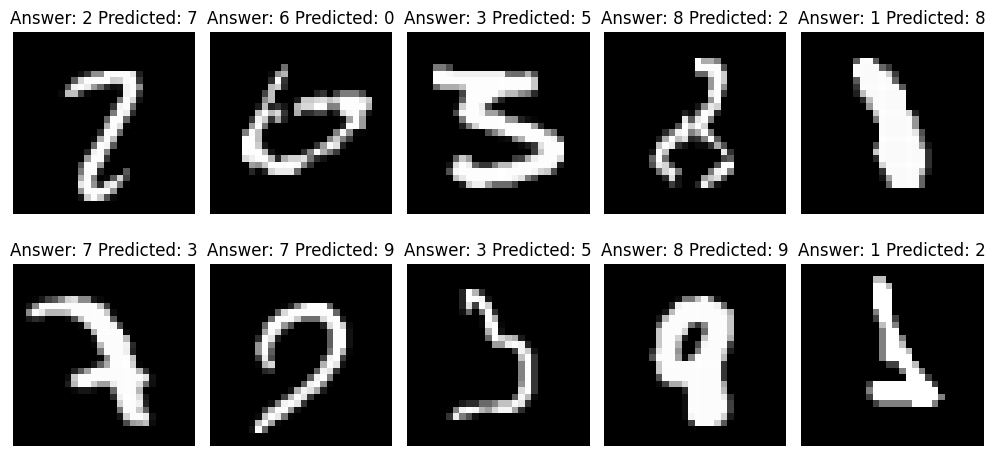

In [60]:
plt.figure(figsize=(10, 5))

# Plot the first 10 images
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid, 1-based index
    plt.imshow(intelligible[i][0].cpu().numpy(), cmap='gray')  # Display the image
    plt.title(f'Answer: {answers[i]} Predicted: {model_predictions[i]}')  # Show the label
    plt.axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# build a checkpoint
checkpoint = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": actual_loss,
}
torch.save(checkpoint, "checkpoint.pth")

In [ ]:
loaded_checkpoint = torch.load("checkpoint.pth")
print(loaded_checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


<ipython-input-19-31e90998f733>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load("checkpoint.pth")


In [ ]:
# train another model with the pre-existing model weights
model2 = SimpleCNN()
model2.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
optimizer2.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch2 = loaded_checkpoint['epoch']

for key in model2.state_dict():
  if torch.all(model.state_dict()[key] == model2.state_dict()[key]):
    print(f'{key} matches')
  else:
    print(f"{key} doesn't match")

for epoch in range(epochs):
  running_loss = 0.0
  for images, labels in trainloader:
    outputs = model2(images)
    loss = criterion(outputs, labels)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

    running_loss += loss.item()
    actual_loss = running_loss/len(trainloader)

  print(f'Epoch: {epoch+epoch2+1}, Loss: {actual_loss}')


cnn1.weight matches
cnn1.bias matches
cnn2.weight matches
cnn2.bias matches
fc.weight matches
fc.bias matches
Epoch: 5, Loss: 0.06766068123791888
Epoch: 6, Loss: 0.06310790288684494
Epoch: 7, Loss: 0.05800674252685163
Epoch: 8, Loss: 0.05589606323957308
Epoch: 9, Loss: 0.05376157179060357
